La importancia de reducir el riesgo crediticio ha llevado a una institución financiera alemana a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para construir un modelo de machine learning preciso y confiable que sea capaz de evaluar con mayor precisión la probabilidad de incumplimiento crediticio de sus clientes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report


# 1. Preprocesamiento de Datos

#**Descripción de Variables del Dataset de Credit Scoring**

- **status**: Estado del crédito, indicando la situación actual del mismo.
- **seniority**: Años de experiencia laboral del solicitante.
- **home**: Tipo de vivienda del solicitante.
- **time**: Plazo del préstamo en meses.
- **age**: Edad del solicitante.
- **marital**: Estado civil del solicitante.
- **records**: Historial de créditos previos del solicitante.
- **job**: Tipo de trabajo o categoría ocupacional.
- **expenses**: Gastos mensuales reportados.
- **income**: Ingresos mensuales del solicitante.
- **assets**: Valor de los ahorros o activos.
- **debt**: Obligaciones financieras actuales.
- **amount**: Monto solicitado en el préstamo.
- **price**: Prima o valor total a devolver por el crédito.


In [3]:
# load dataset of credit scoring

Xfiles = pd.read_csv("CreditRisk.csv")  # read CSV with pandas read_csv
data = Xfiles.copy()                    # copy dataset
data.head(10)                       # look with Head()


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910
5,ok,1,owner,60,36,married,no,fixed,75,214,3500,0,650,1645
6,ok,29,owner,60,44,married,no,fixed,75,125,10000,0,1600,1800
7,ok,9,parents,12,27,single,no,fixed,35,80,0,0,200,1093
8,ok,0,owner,60,32,married,no,freelance,90,107,15000,0,1200,1957
9,default,0,parents,48,41,married,no,partime,90,80,0,0,1200,1468


In [4]:
# Look duplicated

duplicadas = data[data.duplicated(keep=False)]
duplicadas


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
1021,default,5,owner,60,36,married,no,freelance,90,62,3000,0,650,1295
1022,default,5,owner,60,36,married,no,freelance,90,62,3000,0,650,1295
2928,ok,4,owner,60,37,married,no,freelance,35,128,18000,0,800,1560
2929,ok,4,owner,60,37,married,no,freelance,35,128,18000,0,800,1560


In [5]:

print("There are ", data.duplicated().sum(), "duplicate valors in the dataset ")

There are  2 duplicate valors in the dataset 


In [6]:
# Drop row duplicated
data_within_duplicated = data.drop_duplicates()

print(data.shape)
print(data_within_duplicated.shape)
print(data_within_duplicated.duplicated().sum())

(4455, 14)
(4453, 14)
0


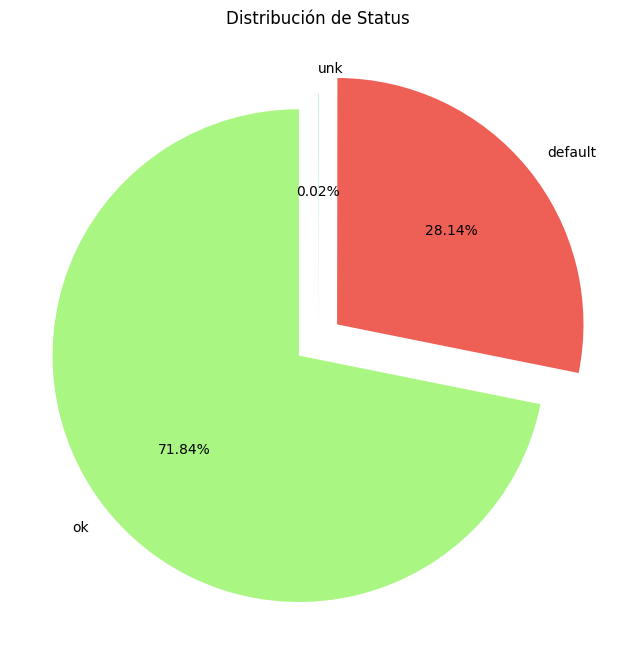

In [ ]:
# Count the frequencies of each value in the 'status' column

status_counts = data_within_duplicated['status'].value_counts()   

# Create the cake diagram

colores = ["#AAF683","#EE6055","#60D394","#FFD97D","#FF9B85"]
desfase = (0.1, 0.1, 0)
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.2f%%', startangle=90, colors=colores, explode=desfase)
plt.title('Distribución de Status')
plt.show()


## 1.1 Formato de la columna Default

In [8]:
data_within_duplicated.status.unique()

array(['ok', 'default', 'unk'], dtype=object)

In [9]:
Columna_default = data_within_duplicated.status.value_counts()
Columna_default 

status
ok         3199
default    1253
unk           1
Name: count, dtype: int64

In [10]:
# We see the row that contains the UNK value to analyze and send it to OK or default
unk = data_within_duplicated[data_within_duplicated.status == 'unk']
unk


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
3309,unk,10,private,60,25,single,no,fixed,35,148,3000,0,1500,1888


In [11]:
data_treatment = data_within_duplicated.copy()

# Reemplazar 'unk' por 'ok' en la columna 'status' , Because home is private and amount 1500
data_treatment['status'] = data_treatment['status'].replace('unk', 'ok')

In [12]:
# Crear una nueva columna binaria: 0 para 'ok', 1 para 'default'
data_treatment['default'] = data_treatment['status'].apply(lambda x: 1 if x == 'default' else 0)
data_treatment.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [13]:
data_treatment.drop('status', axis=1, inplace=True)
data_treatment.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [14]:
# Mostrar el conteo de la columna 'default' con formato

default_counts = data_treatment['default'].value_counts().reset_index()
default_counts.columns = ['default','count']
print(default_counts)


   default  count
0        0   3200
1        1   1253


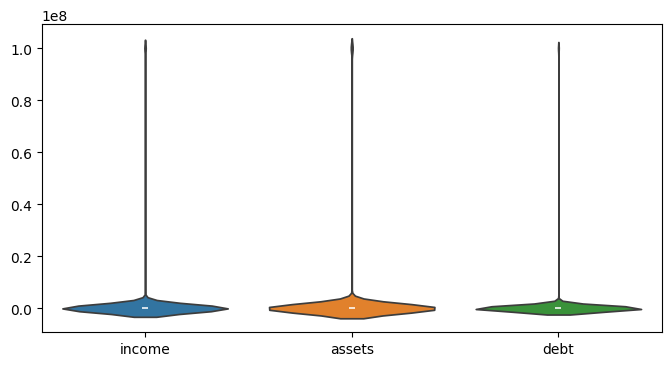

In [15]:
# Crear un gráfico de violín para las tres variables
plt.figure(figsize=(8, 4))
sns.violinplot(data=data_treatment[['income', 'assets', 'debt']])

# Mostrar el gráfico
plt.show()

## 1.2 Datos anomalos


In [16]:
#Have a little problem with outliers in income, assets and debt values

data_treatment.describe().round(0)

,seniority,time,age,expenses,income,assets,debt,amount,price,default
count,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0
mean,8.0,46.0,37.0,56.0,763660.0,1060812.0,404564.0,1039.0,1463.0,0.0
std,8.0,15.0,11.0,20.0,8705565.0,10219839.0,6345672.0,475.0,628.0,0.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0,0.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0,0.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0,0.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0,1.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0,1.0


In [17]:
outliers = data_treatment[data_treatment.income > 100000]
outliers

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
29,0,unk,48,37,single,no,unk,35,99999999,99999999,99999999,1500,1850,1
393,1,owner,36,52,married,yes,freelance,60,99999999,100000,20000,1500,2340,1
803,6,parents,24,25,single,no,fixed,35,99999999,5000,0,850,1480,0
1306,12,owner,36,41,married,no,freelance,60,99999999,10000,0,1000,2100,0
1420,0,owner,60,36,married,yes,freelance,75,99999999,6000,0,1650,1861,1
1436,5,rent,24,29,married,no,freelance,45,99999999,0,0,800,1197,0
1455,2,owner,36,19,single,yes,freelance,35,99999999,9000,0,500,1100,1
1472,15,owner,60,40,married,yes,freelance,75,99999999,16000,0,1150,1850,0
1534,1,owner,60,39,married,no,freelance,60,99999999,6000,3000,850,1104,1
1543,10,owner,36,43,married,no,freelance,60,99999999,4500,0,1000,1905,1


In [18]:
# We replace the Outliers 999999 Values ​​with NAN values ​​and continue analyzing.

data_treatment.replace(99999999, np.nan, inplace=True)


In [19]:
outliers = data_treatment[data_treatment.income > 100000]
outliers

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default


## 1.3 Imputando Datos

In [20]:
null = data_treatment.isnull().sum()
null

seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
default       0
dtype: int64

In [21]:
# Reemplazar NaN con la mediana solo en columnas numéricas
data_treatment[data_treatment.select_dtypes(include=np.number).columns] = data_treatment.select_dtypes(include=np.number).apply(lambda x: x.fillna(x.median()))



In [22]:
# verify the null and descriptive data
null = data_treatment.isnull().sum()
null

seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
default      0
dtype: int64

In [23]:
# verify the null and descriptive data
data_treatment.describe().round(0)

,seniority,time,age,expenses,income,assets,debt,amount,price,default
count,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0
mean,8.0,46.0,37.0,56.0,131.0,5376.0,342.0,1039.0,1463.0,0.0
std,8.0,15.0,11.0,20.0,86.0,11516.0,1244.0,475.0,628.0,0.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0,0.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0,0.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0,0.0
75%,12.0,60.0,45.0,72.0,164.0,6000.0,0.0,1300.0,1692.0,1.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0,1.0


## 1.4 Descriptivos Numericos

In [24]:
numerics = data_treatment.columns
numerics

Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
      dtype='object')

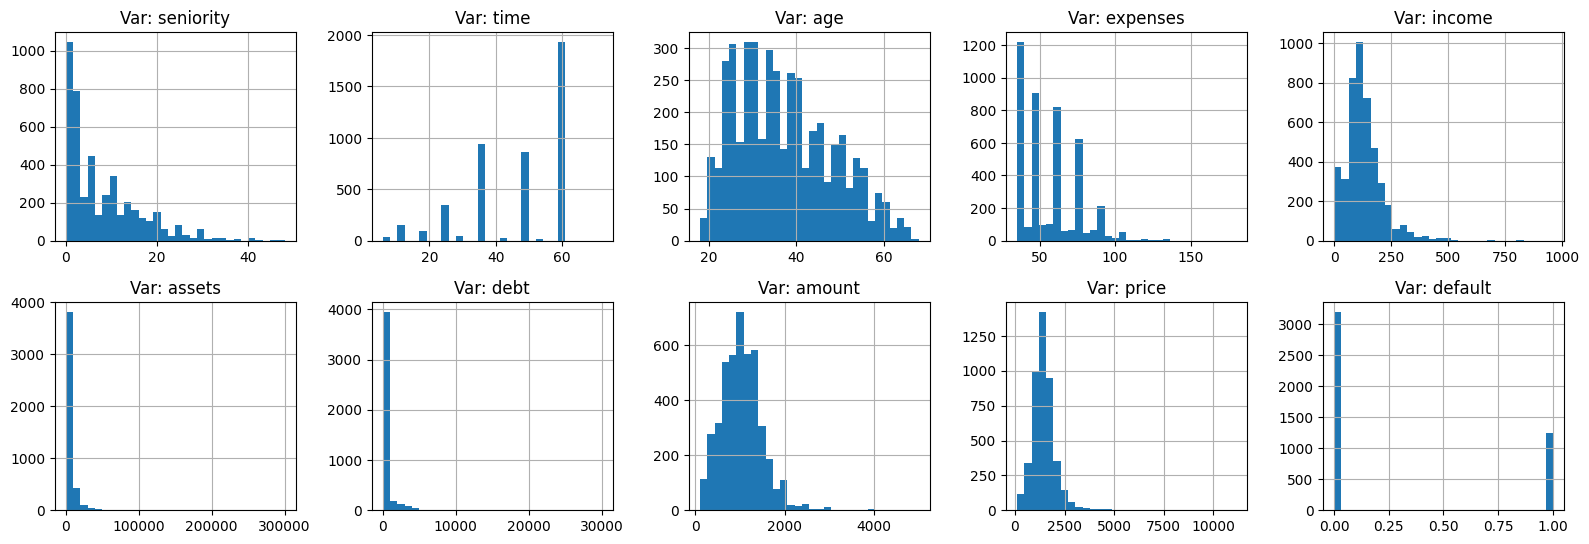

In [25]:
# Seleccionar las columnas numéricas
num_cols = data_treatment.select_dtypes(include=np.number).columns

# Ajustar el tamaño de la cuadrícula según el número de columnas
filas = (len(num_cols) // 5) + 1
columnas = 5

# Crear la figura con subgráficas
fig, axes = plt.subplots(filas, columnas, figsize=(16, 8))
axes = axes.flatten()                                           # Convertir a un arreglo 1D para iterar fácilmente

# Iterar por las columnas numéricas y crear un histograma
for i, col in enumerate(num_cols):
    data_treatment[col].hist(ax=axes[i], bins=30)               # bins=30 ajusta el número de barras
    axes[i].set_title(f"Var: {col}")

# Ocultar las gráficas vacías si hay menos de 10 columnas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()                                              # Ajustar los márgenes
plt.show()

## 1.5 Truncando valores atipicos

In [26]:
trunc = {'expenses':0.99,'income':0.99,'assets':0.99,'debt':0.99,'amount':0.99,'price':0.99}

In [35]:

for var, perc in trunc.items():
    upper_bound = data_treatment[var].quantile(perc)  # Calcula el percentil 99
    print(f"Se trunca {var} en {upper_bound:.2f}")
    data_treatment[var] = np.clip(data_treatment[var], None, upper_bound)  # Trunca los valores superiores

Se trunca expenses en 106.01
Se trunca income en 428.02
Se trunca assets en 50000.00
Se trunca debt en 4750.61
Se trunca amount en 2500.00
Se trunca price en 3559.01


In [37]:
# Resumen estadístico después del truncamiento
data_treatment.describe().round(0)

,seniority,time,age,expenses,income,assets,debt,amount,price,default
count,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0
mean,8.0,46.0,37.0,55.0,129.0,4992.0,304.0,1034.0,1450.0,0.0
std,8.0,15.0,11.0,19.0,79.0,7685.0,874.0,449.0,547.0,0.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0,0.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0,0.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0,0.0
75%,12.0,60.0,45.0,72.0,164.0,6000.0,0.0,1300.0,1692.0,1.0
max,48.0,72.0,68.0,106.0,428.0,50000.0,4751.0,2500.0,3559.0,1.0


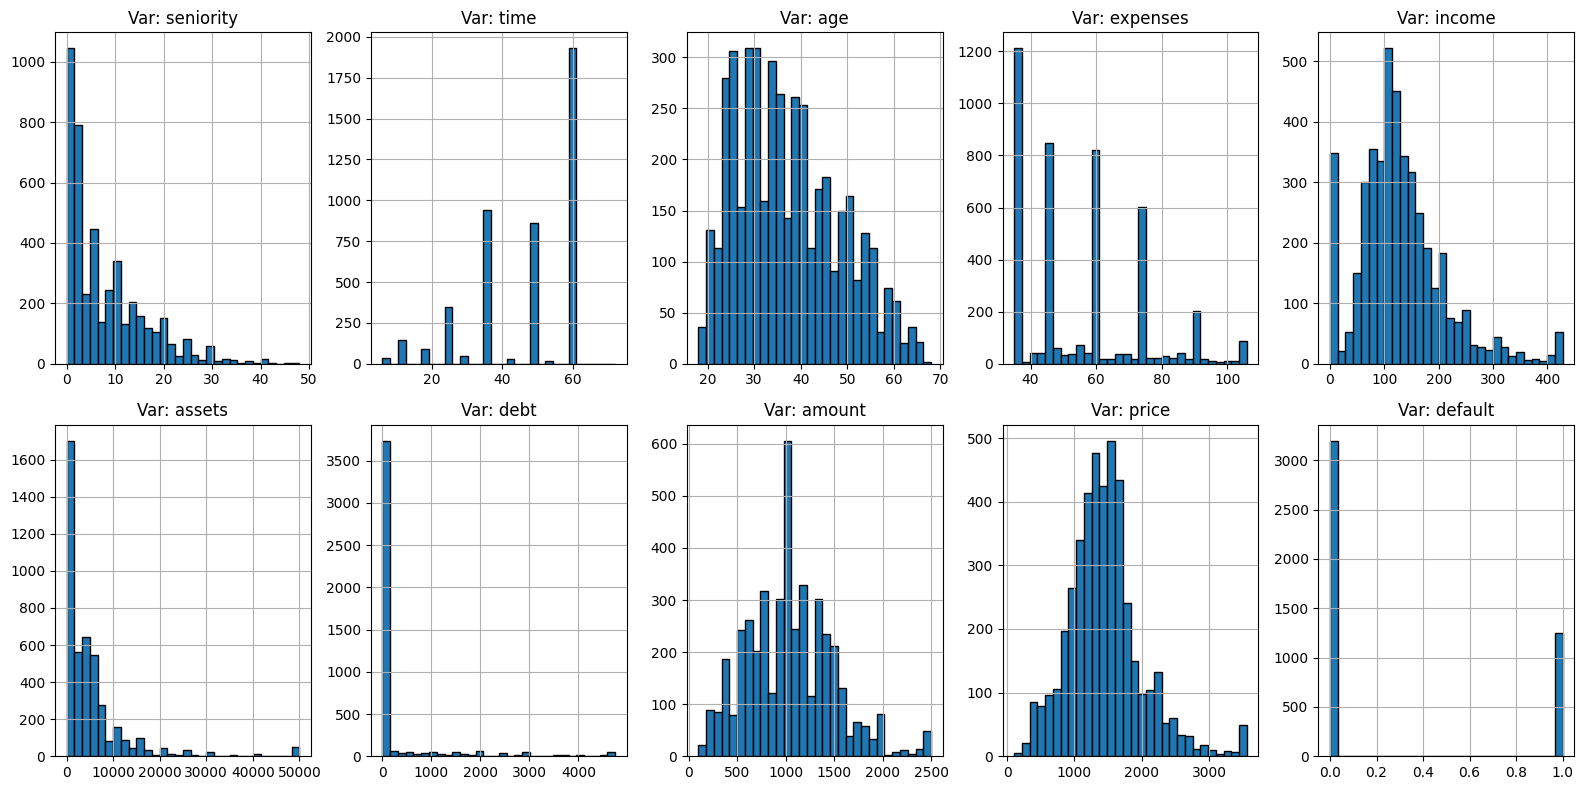

In [ ]:
# Visualización de las distribuciones después del truncamiento
num_cols = data_treatment.select_dtypes(include=np.number).columns      # Seleccionar solo columnas numéricas
fig, axes = plt.subplots(2, 5, figsize=(16, 8))                         # Crear una cuadrícula de 2 filas por 5 columnas
ax_flat = axes.flatten()                                                # Aplanar el arreglo de ejes para iterar

for i, col in enumerate(num_cols):
    data_treatment[col].hist(ax=ax_flat[i], bins=30, edgecolor='black')
    ax_flat[i].set_title(f"Var: {col}")

plt.tight_layout()                                                      # Ajusta automáticamente el diseño
plt.show()

## 1.6 Descriptivos Cualitativos

In [ ]:
cuali = data_treatment.select_dtypes('object')
cuali.describe()

,home,marital,records,job
count,4453,4453,4453,4453
unique,7,6,2,5
top,owner,married,no,fixed
freq,2105,3239,3680,2806


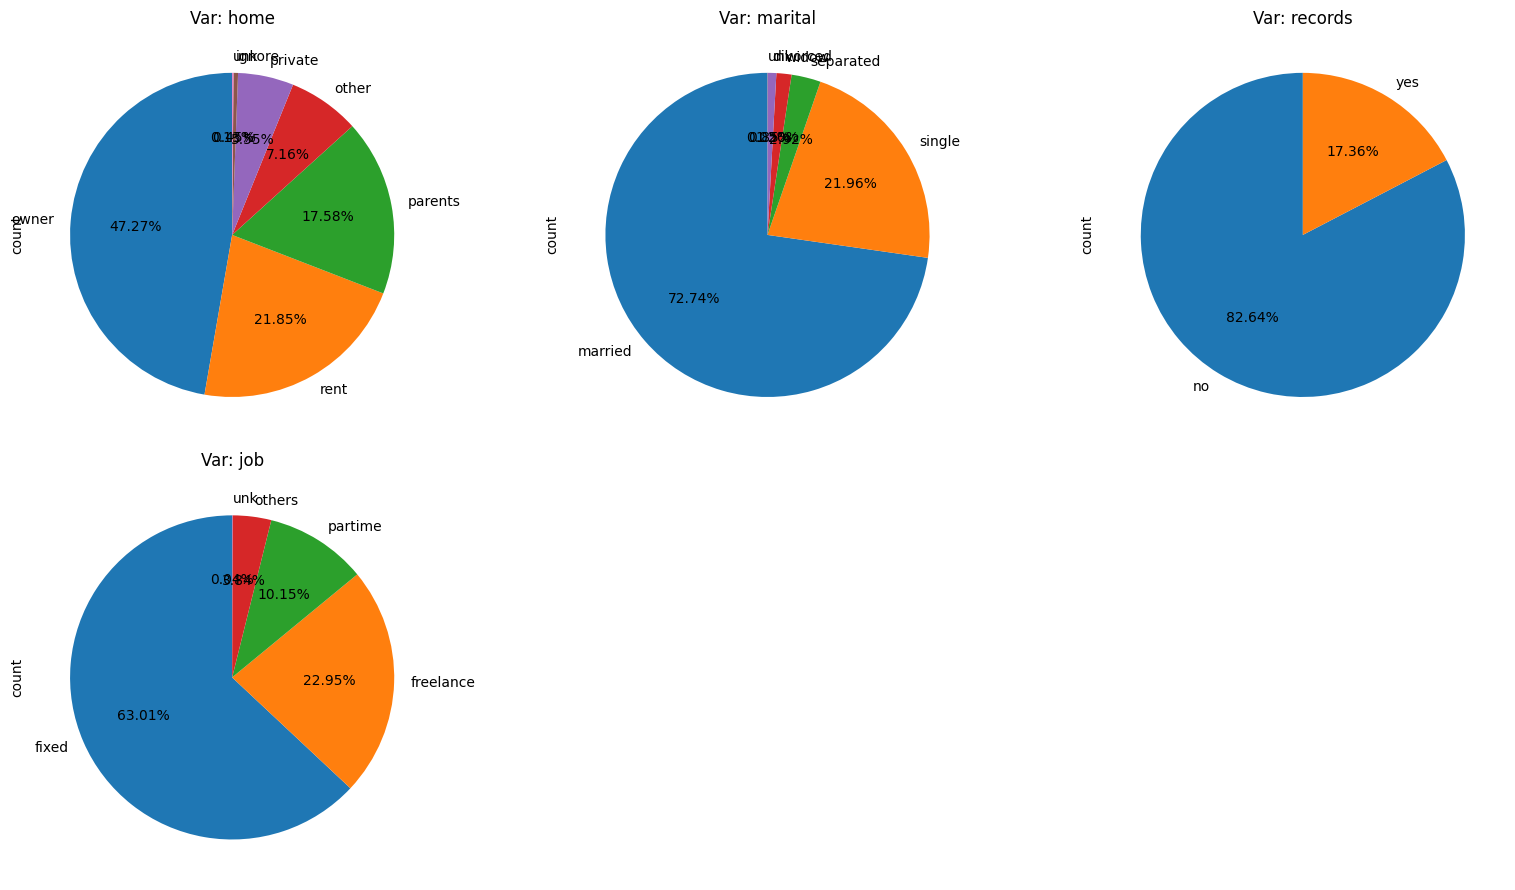

In [ ]:
# Seleccionar las columnas categóricas
categorical_cols = data_treatment.select_dtypes(include='object').columns

# Crear el diseño de subgráficas
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

# Generar una gráfica de pastel por cada columna categórica
for i, col in enumerate(categorical_cols):
    data_treatment[col].value_counts().plot.pie(
        ax=axes[i],
        autopct='%1.2f%%',
        startangle=90,
        legend=False,
        title=f"Var: {col}"
    )
    axes[i].set_ylabel('count')  # Etiqueta del eje y

# Ocultar cualquier gráfico adicional si no se usa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 1.7 Reagrupando categorias

In [71]:
# Contar las frecuencias de la columna 'home'
frequency_home = data_treatment['home'].value_counts().reset_index()

# Renombrar las columnas para que coincidan con tu formato
frequency_home.columns = ['home', 'count']
frequency_home

,home,count
0,owner,2105
1,rent,973
2,parents,783
3,other,319
4,private,247
5,ignore,20
6,unk,6


In [72]:
frecuencia_home = data_treatment['home'].value_counts(normalize=True).reset_index()
frecuencia_home.columns = ['home', 'proporcion']
umbral = 0.05

# Filtrar las categorías menos representativas
low_frequency = frecuencia_home[frecuencia_home['proporcion'] < umbral]
low_frequency

,home,proporcion
5,ignore,0.004491
6,unk,0.001347


In [73]:
# replace the little representative category in others
categorias_low_frequency = low_frequency.index
categorias_low_frequency
data_treatment['home'] = data_treatment['home'].replace(categorias_low_frequency, 'other')

In [69]:
# Contar las frecuencias de la columna 'home'
frequency_home = data_treatment['home'].value_counts().reset_index()

# Renombrar las columnas para que coincidan con tu formato
frequency_home.columns = ['home', 'count']
frequency_home

,home,count
0,owner,2105
1,rent,973
2,parents,783
3,other,319
4,private,247
5,ignore,20
6,unk,6
